# BASELINE

Uruchamia jeden prosty model i jedną metryke na zbiorze

1. Wczytanie danych
2. Dzielenie na zbiór testowy i treningowy
3. Uruchomienie modelu RandomForest
4. Obliczenie metryki RMSE
5. Wizualizacja



In [1]:
# Import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Ustawienia
pd.set_option('display.max_columns', None)

print("Gotowe")

Gotowe


## 1. Wczytanie danych


In [2]:
# Wczytanie danych

df = pd.read_csv('../data/02_interim/wec_lap_data_cleaned.csv')


## 2. Dzielenie na zbiór testowy i treningowy

In [5]:
# Przygotowanie zbioru do modelowania zgodnie z EDA
# 1) Upewniam się, że jest lap_time_seconds
if 'lap_time_seconds' not in df.columns and 'lap_time' in df.columns:
    df['lap_time_seconds'] = pd.to_timedelta(df['lap_time'], errors='coerce').dt.total_seconds()

# 2) Upewniam się, że jest pit_time_seconds i braki=0
if 'pit_time_seconds' not in df.columns and 'pit_time' in df.columns:
    df['pit_time_seconds'] = pd.to_timedelta(df['pit_time'], errors='coerce').dt.total_seconds()
if 'pit_time_seconds' in df.columns:
    df['pit_time_seconds'] = df['pit_time_seconds'].fillna(0)

# 3) Filtrowanie: bez pitów i 1.–99. percentyl
df_model = df.copy()
if 'pit_time_seconds' in df_model.columns:
    df_model = df_model[df_model['pit_time_seconds'] == 0]
if 'lap_time_seconds' in df_model.columns:
    low, high = df_model['lap_time_seconds'].quantile([0.01, 0.99])
    df_model = df_model[(df_model['lap_time_seconds'] >= low) & (df_model['lap_time_seconds'] <= high)]

# 4) Klasa: biorę najczęstszą
CLASS_TO_MODEL = None
if 'class' in df_model.columns and df_model['class'].nunique() > 1:
    CLASS_TO_MODEL = df_model['class'].mode()[0]
    df_model = df_model[df_model['class'] == CLASS_TO_MODEL]

# 5) Target i cechy - TYLKO NUMERYCZNE (unikamy MemoryError)
assert 'lap_time_seconds' in df_model.columns, "Brak kolumny lap_time_seconds"
target_col = 'lap_time_seconds'
y = df_model[target_col]

# Wybierz TYLKO kolumny numeryczne
X = df_model.drop(columns=[target_col]).select_dtypes(include=['number'])
print(f"Wybrano {X.shape[1]} cech numerycznych")

# Braki -> 0
X = X.fillna(0)

# Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

MemoryError: Unable to allocate 22.4 GiB for an array with shape (155220, 154944) and data type bool

## 3. Uruchomienie modelu

In [6]:
# Model bazowy
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

NameError: name 'X_train' is not defined

## 4. Obliczenie metryki

## 5. Wizualizacja

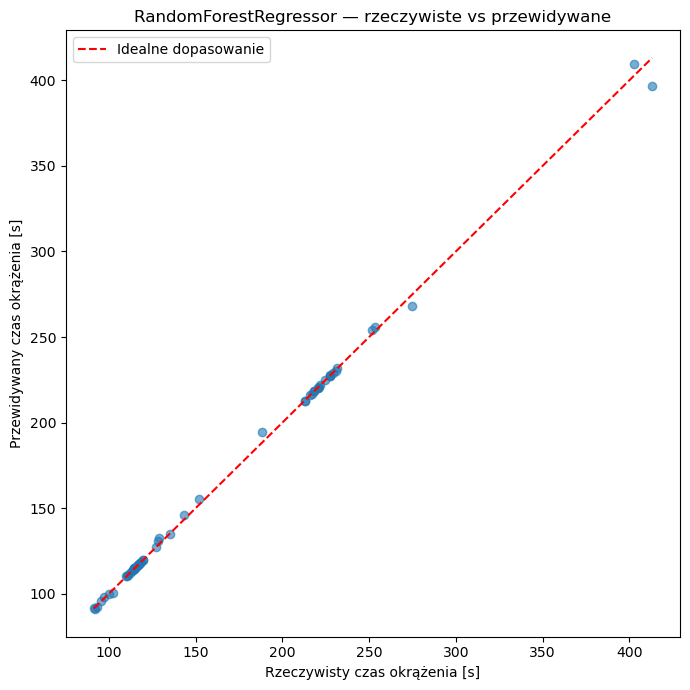

In [16]:
#  Wizualizacja: rzeczywiste vs. przewidywane
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Idealne dopasowanie')
plt.xlabel("Rzeczywisty czas okrążenia [s]")
plt.ylabel("Przewidywany czas okrążenia [s]")
plt.title("RandomForestRegressor — rzeczywiste vs przewidywane")
plt.legend()
plt.tight_layout()
plt.show()